In [1]:
!git clone https://github.com/isl-org/DPT.git

# Download models and weights
#!wget https://github.com/intel-isl/DPT/releases/download/1_0/dpt_hybrid-midas-501f0c75.pt
#!wget https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-midas-2f21e586.pt
#!wget https://github.com/intel-isl/DPT/releases/download/1_0/dpt_hybrid-ade20k-53898607.pt
!wget https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-ade20k-b12dca68.pt
    
# Import weights
#!mv ./dpt_hybrid-ade20k-53898607.pt ./DPT/weights
!mv ./dpt_large-ade20k-b12dca68.pt ./DPT/weights
#!mv ./dpt_large-midas-2f21e586.pt ./DPT/weights
#!mv ./dpt_hybrid-midas-501f0c75.pt ./DPT/weights

# Pip install required libraries with last releases
!pip install torch
!pip install torchvision
!pip install opencv-python
!pip install timm

Cloning into 'DPT'...
remote: Enumerating objects: 782, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 782 (delta 144), reused 113 (delta 113), pack-reused 606 (from 1)
Receiving objects: 100% (782/782), 458.16 KiB | 5.33 MiB/s, done.
Resolving deltas: 100% (371/371), done.
--2025-05-10 16:20:04--  https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-ade20k-b12dca68.pt
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/isl-org/DPT/releases/download/1_0/dpt_large-ade20k-b12dca68.pt [following]
--2025-05-10 16:20:04--  https://github.com/isl-org/DPT/releases/download/1_0/dpt_large-ade20k-b12dca68.pt
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-p

In [2]:
!ls

DPT


In [3]:
!cd ../input/dataset-v1/d1/ && ls

informative_signal  prevention_sign  regulation_sign


In [4]:
import os 
def initialize_system():
    # Generate output directory
    if(not(os.path.isdir('/kaggle/working/output'))):
        os.mkdir('/kaggle/working/output')
    
    filename = "/kaggle/working/DPT/run_monodepth.py"
    text = open(filename).read()
    open(filename, "w+").write(text.replace('"output_monodepth"', '"/kaggle/working/DPT/output_monodepth"'))

    filename = "/kaggle/working/DPT/run_segmentation.py"
    text = open(filename).read()
    open(filename, "w+").write(text.replace('"output_semseg"', '"/kaggle/working/DPT/output_semseg"'))
    
    filename = "/kaggle/working/DPT/run_monodepth.py"
    text = open(filename).read()

    #Here goes your files
    open(filename, "w+").write(text.replace('"input"', '"/kaggle/working/DPT/input/"'))

    filename = "/kaggle/working/DPT/run_segmentation.py"
    text = open(filename).read()

    #Here goes your files
    open(filename, "w+").write(text.replace('"input"', '"/kaggle/working/DPT/input/"'))
    
    filename = "/kaggle/working/DPT/run_monodepth.py"
    text = open(filename).read()
    open(filename, "w+").write(text.replace('"weights/', '"/kaggle/working/DPT/weights/'))

    filename = "/kaggle/working/DPT/run_segmentation.py"
    text = open(filename).read()
    open(filename, "w+").write(text.replace('"weights/', '"/kaggle/working/DPT/weights/'))

In [5]:
initialize_system()

In [6]:
with open("DPT/dpt/base_model.py", "r") as f:
    code = f.read()

code = code.replace(
    "self.load_state_dict(parameters)",
    """own_state = self.state_dict()
        filtered = {k: v for k, v in parameters.items() if k in own_state and v.shape == own_state[k].shape}
        print(f"Cargando {len(filtered)} de {len(own_state)} parámetros del checkpoint.")
        self.load_state_dict(filtered, strict=False)"""
)


with open("DPT/dpt/base_model.py", "w") as f:
    f.write(code)

In [7]:
# Leer contenido original
with open("DPT/dpt/models.py", "r") as f:
    code = f.read()

# Añadir el nuevo método seguro al final del archivo si no existe
if "def load_partial_weights" not in code:
    code += """

    def load_partial_weights(self, path):
        parameters = torch.load(path, map_location="cpu")
        if "model" in parameters:
            parameters = parameters["model"]

        own_state = self.state_dict()
        filtered = {
            k: v for k, v in parameters.items()
            if k in own_state and v.shape == own_state[k].shape
        }

        print(f"Cargando {len(filtered)} de {len(own_state)} parámetros del checkpoint.")
        self.load_state_dict(filtered, strict=False)
"""



# Guardar cambios
with open("DPT/dpt/models.py", "w") as f:
    f.write(code)

print("Archivo 'models.py' modificado exitosamente.")


!cat DPT/dpt/models.py

Archivo 'models.py' modificado exitosamente.
import torch
import torch.nn as nn
import torch.nn.functional as F

from .base_model import BaseModel
from .blocks import (
    FeatureFusionBlock,
    FeatureFusionBlock_custom,
    Interpolate,
    _make_encoder,
    forward_vit,
)


def _make_fusion_block(features, use_bn):
    return FeatureFusionBlock_custom(
        features,
        nn.ReLU(False),
        deconv=False,
        bn=use_bn,
        expand=False,
        align_corners=True,
    )


class DPT(BaseModel):
    def __init__(
        self,
        head,
        features=256,
        backbone="vitb_rn50_384",
        readout="project",
        channels_last=False,
        use_bn=False,
        enable_attention_hooks=False,
    ):

        super(DPT, self).__init__()

        self.channels_last = channels_last

        hooks = {
            "vitb_rn50_384": [0, 1, 8, 11],
            "vitb16_384": [2, 5, 8, 11],
            "vitl16_384": [5, 11, 17, 23],
        }

        # In

In [8]:
!cat DPT/dpt/base_model.py

import torch


class BaseModel(torch.nn.Module):
    def load(self, path):
        """Load model from file.

        Args:
            path (str): file path
        """
        parameters = torch.load(path, map_location=torch.device("cpu"))

        if "optimizer" in parameters:
            parameters = parameters["model"]

        own_state = self.state_dict()
        filtered = {k: v for k, v in parameters.items() if k in own_state and v.shape == own_state[k].shape}
        print(f"Cargando {len(filtered)} de {len(own_state)} parámetros del checkpoint.")
        self.load_state_dict(filtered, strict=False)


In [9]:
# ===============================
# IMPORTS
# ===============================
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import f1_score
from DPT.dpt.models import DPTSegmentationModel

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [10]:
# ===============================
# DATASET CON ALBUMENTATIONS
# ===============================
class RoadSignSegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        subdirs = [os.path.join(root_dir, d) for d in os.listdir(root_dir)
                   if os.path.isdir(os.path.join(root_dir, d))]

        for subdir in subdirs:
            for fname in os.listdir(subdir):
                if fname.endswith("_img.png"):
                    base = fname.replace("_img.png", "")
                    img_path = os.path.join(subdir, f"{base}_img.png")
                    mask_path = os.path.join(subdir, f"{base}_label.png")
                    label_names_path = os.path.join(subdir, f"{base}_label_names.txt")

                    if os.path.exists(mask_path):
                        label_names = []
                        if os.path.exists(label_names_path):
                            with open(label_names_path, 'r') as f:
                                label_names = [line.strip() for line in f.readlines()]

                        self.samples.append({
                            "image": img_path,
                            "mask": mask_path,
                            "labels": label_names
                        })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        image = np.array(Image.open(sample["image"]).convert("RGB"))
        mask = np.array(Image.open(sample["mask"]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"].long()

        return image, mask, sample["labels"]

In [11]:
# ===============================
# TRANSFORMACIONES
# ===============================
train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.2),
    A.Affine(
        scale=(0.8, 1.2),
        translate_percent={"x": 0.05, "y": 0.05},
        rotate=(-15, 15),
        p=0.5
    ),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

In [12]:
# ===============================
# MÉTRICAS
# ===============================
def compute_iou(pred, target, num_classes=2):
    ious = []
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum()
        union = (pred_inds | target_inds).sum()
        if union == 0:
            ious.append(np.nan)
        else:
            ious.append(intersection / union)
    return np.nanmean(ious)

def pixel_accuracy(pred, target):
    correct = (pred == target).sum()
    total = target.size
    return correct / total


In [13]:
# ===============================
# DATASET
# ===============================
dataset = RoadSignSegmentationDataset(
    root_dir="../input/dataset-v2/d2/",
    transform=train_transform
)

In [14]:
for image, mask, labels in dataset:
    print(labels)
    break

['_background_', 'prevention']


In [41]:
# ===============================
# CONFIGURACIÓN
# ===============================
NUM_CLASSES = 4
BATCH_SIZE = 8
NUM_EPOCHS = 15
LEARNING_RATE = 1e-4
VAL_SPLIT = 0.2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===============================
# DATALOADER
# ===============================
val_size = int(VAL_SPLIT * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(len(train_dataset))
print(len(val_dataset))

193
48


In [42]:
# ===============================
# MODELO
# ===============================
model = DPTSegmentationModel(
    num_classes=NUM_CLASSES,
    backbone="vitl16_384",
    readout="project",
    features=256,
    use_bn=True
)

model.load_partial_weights("DPT/weights/dpt_large-ade20k-b12dca68.pt")
model.to(DEVICE)

/kaggle/working/DPT/dpt/models.py:157: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  parameters = torch.load(path, map_location="cpu")


Cargando 438 de 442 parámetros del checkpoint.


DPTSegmentationModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in

In [43]:
# ===============================
# CONGELAR BACKBONE
# ===============================
for param in model.pretrained.parameters():
    param.requires_grad = False

In [44]:
print(DEVICE)

cuda


[Train] Epoch 1: 100%|██████████| 25/25 [02:36<00:00,  6.28s/it]


[Train] Epoch 1 | Loss: 0.7057 | IoU: 0.6432 | Acc: 0.8882 | F1: 0.3710
[Val]   Epoch 1 | Loss: 0.3213 | IoU: 0.7480 | Acc: 0.9844 | F1: 0.7406


[Train] Epoch 2: 100%|██████████| 25/25 [02:40<00:00,  6.42s/it]


[Train] Epoch 2 | Loss: 0.2711 | IoU: 0.7680 | Acc: 0.9918 | F1: 0.5827
[Val]   Epoch 2 | Loss: 0.1842 | IoU: 0.7702 | Acc: 0.9935 | F1: 0.8004


[Train] Epoch 3: 100%|██████████| 25/25 [02:39<00:00,  6.38s/it]


[Train] Epoch 3 | Loss: 0.1873 | IoU: 0.7802 | Acc: 0.9934 | F1: 0.7246
[Val]   Epoch 3 | Loss: 0.1577 | IoU: 0.8241 | Acc: 0.9950 | F1: 0.8543


[Train] Epoch 4: 100%|██████████| 25/25 [02:42<00:00,  6.49s/it]


[Train] Epoch 4 | Loss: 0.1473 | IoU: 0.8076 | Acc: 0.9949 | F1: 0.8068
[Val]   Epoch 4 | Loss: 0.1357 | IoU: 0.8197 | Acc: 0.9953 | F1: 0.8467


[Train] Epoch 5: 100%|██████████| 25/25 [02:40<00:00,  6.42s/it]


[Train] Epoch 5 | Loss: 0.1148 | IoU: 0.8147 | Acc: 0.9951 | F1: 0.8195
[Val]   Epoch 5 | Loss: 0.1074 | IoU: 0.8181 | Acc: 0.9949 | F1: 0.8467


[Train] Epoch 6: 100%|██████████| 25/25 [02:41<00:00,  6.45s/it]


[Train] Epoch 6 | Loss: 0.0951 | IoU: 0.8373 | Acc: 0.9959 | F1: 0.8529
[Val]   Epoch 6 | Loss: 0.0941 | IoU: 0.8295 | Acc: 0.9951 | F1: 0.8609


[Train] Epoch 7: 100%|██████████| 25/25 [02:42<00:00,  6.51s/it]


[Train] Epoch 7 | Loss: 0.0839 | IoU: 0.8186 | Acc: 0.9957 | F1: 0.8469
[Val]   Epoch 7 | Loss: 0.0836 | IoU: 0.8297 | Acc: 0.9956 | F1: 0.8548


[Train] Epoch 8: 100%|██████████| 25/25 [02:41<00:00,  6.47s/it]


[Train] Epoch 8 | Loss: 0.0771 | IoU: 0.8425 | Acc: 0.9963 | F1: 0.8528
[Val]   Epoch 8 | Loss: 0.0815 | IoU: 0.8527 | Acc: 0.9958 | F1: 0.8825


[Train] Epoch 9: 100%|██████████| 25/25 [02:42<00:00,  6.51s/it]


[Train] Epoch 9 | Loss: 0.0787 | IoU: 0.8506 | Acc: 0.9967 | F1: 0.8709
[Val]   Epoch 9 | Loss: 0.0735 | IoU: 0.8444 | Acc: 0.9956 | F1: 0.8719


[Train] Epoch 10: 100%|██████████| 25/25 [02:42<00:00,  6.49s/it]


[Train] Epoch 10 | Loss: 0.0682 | IoU: 0.8588 | Acc: 0.9967 | F1: 0.8910
[Val]   Epoch 10 | Loss: 0.0775 | IoU: 0.8229 | Acc: 0.9947 | F1: 0.8524


[Train] Epoch 11: 100%|██████████| 25/25 [02:41<00:00,  6.47s/it]


[Train] Epoch 11 | Loss: 0.0614 | IoU: 0.8354 | Acc: 0.9966 | F1: 0.8634
[Val]   Epoch 11 | Loss: 0.0678 | IoU: 0.8351 | Acc: 0.9954 | F1: 0.8604


[Train] Epoch 12: 100%|██████████| 25/25 [02:42<00:00,  6.51s/it]


[Train] Epoch 12 | Loss: 0.0576 | IoU: 0.8654 | Acc: 0.9971 | F1: 0.8951
[Val]   Epoch 12 | Loss: 0.0620 | IoU: 0.8628 | Acc: 0.9963 | F1: 0.8935


[Train] Epoch 13: 100%|██████████| 25/25 [02:43<00:00,  6.52s/it]


[Train] Epoch 13 | Loss: 0.0544 | IoU: 0.8693 | Acc: 0.9970 | F1: 0.9017
[Val]   Epoch 13 | Loss: 0.0630 | IoU: 0.8495 | Acc: 0.9954 | F1: 0.8784


[Train] Epoch 14: 100%|██████████| 25/25 [02:44<00:00,  6.59s/it]


[Train] Epoch 14 | Loss: 0.0519 | IoU: 0.8674 | Acc: 0.9970 | F1: 0.8987
[Val]   Epoch 14 | Loss: 0.0596 | IoU: 0.8477 | Acc: 0.9962 | F1: 0.8768


[Train] Epoch 15: 100%|██████████| 25/25 [02:43<00:00,  6.53s/it]


[Train] Epoch 15 | Loss: 0.0519 | IoU: 0.8736 | Acc: 0.9971 | F1: 0.9033
[Val]   Epoch 15 | Loss: 0.0523 | IoU: 0.8543 | Acc: 0.9959 | F1: 0.8823
Modelo guardado en checkpoints/dpt_finetuned.pt


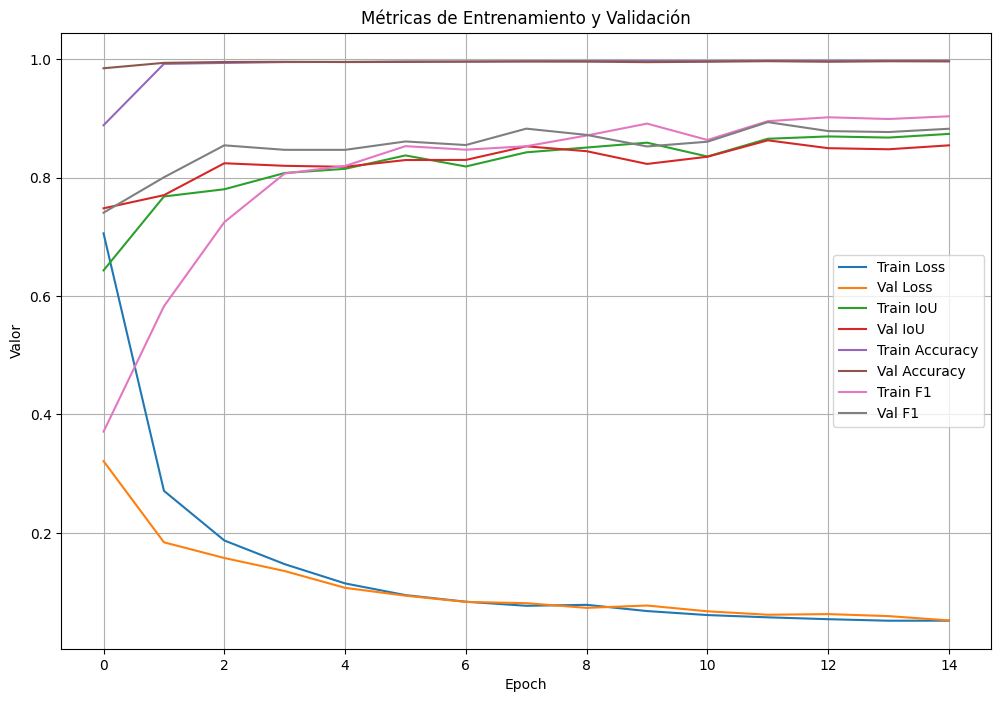

In [45]:
# ===============================
# ENTRENAMIENTO (CONGELADO)
# ===============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

metrics = {
    "train_loss": [], "train_iou": [], "train_acc": [], "train_f1": [],
    "val_loss": [], "val_iou": [], "val_acc": [], "val_f1": []
}

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    train_ious, train_accs, train_f1s = [], [], []

    for images, masks, _ in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        for p, t in zip(preds, masks):
            p_np, t_np = p.cpu().numpy(), t.cpu().numpy()
            train_ious.append(compute_iou(p_np, t_np))
            train_accs.append(pixel_accuracy(p_np, t_np))
            train_f1s.append(f1_score(t_np.flatten(), p_np.flatten(), average="macro"))

    metrics["train_loss"].append(running_loss / len(train_loader))
    metrics["train_iou"].append(np.nanmean(train_ious))
    metrics["train_acc"].append(np.mean(train_accs))
    metrics["train_f1"].append(np.mean(train_f1s))

    # ===============================
    # VALIDACIÓN
    # ===============================
    model.eval()
    val_loss = 0.0
    ious, accs, f1s = [], [], []

    with torch.no_grad():
        for images, masks, _ in val_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            for p, t in zip(preds, masks):
                p_np, t_np = p.cpu().numpy(), t.cpu().numpy()
                ious.append(compute_iou(p_np, t_np))
                accs.append(pixel_accuracy(p_np, t_np))
                f1s.append(f1_score(t_np.flatten(), p_np.flatten(), average="macro"))

    metrics["val_loss"].append(val_loss / len(val_loader))
    metrics["val_iou"].append(np.nanmean(ious))
    metrics["val_acc"].append(np.mean(accs))
    metrics["val_f1"].append(np.mean(f1s))

    print(f"[Train] Epoch {epoch+1} | Loss: {metrics['train_loss'][-1]:.4f} | IoU: {metrics['train_iou'][-1]:.4f} | Acc: {metrics['train_acc'][-1]:.4f} | F1: {metrics['train_f1'][-1]:.4f}")
    print(f"[Val]   Epoch {epoch+1} | Loss: {metrics['val_loss'][-1]:.4f} | IoU: {metrics['val_iou'][-1]:.4f} | Acc: {metrics['val_acc'][-1]:.4f} | F1: {metrics['val_f1'][-1]:.4f}")

    scheduler.step()

# ===============================
# GUARDAR MODELO
# ===============================
os.makedirs("checkpoints", exist_ok=True)
torch.save(model.state_dict(), "checkpoints/dpt_finetuned.pt")
print("Modelo guardado en checkpoints/dpt_finetuned.pt")

# ===============================
# GRÁFICAS
# ===============================
plt.figure(figsize=(12, 8))
plt.plot(metrics["train_loss"], label="Train Loss")
plt.plot(metrics["val_loss"], label="Val Loss")
plt.plot(metrics["train_iou"], label="Train IoU")
plt.plot(metrics["val_iou"], label="Val IoU")
plt.plot(metrics["train_acc"], label="Train Accuracy")
plt.plot(metrics["val_acc"], label="Val Accuracy")
plt.plot(metrics["train_f1"], label="Train F1")
plt.plot(metrics["val_f1"], label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("Valor")
plt.title("Métricas de Entrenamiento y Validación")
plt.grid(True)
plt.legend()
plt.savefig("checkpoints/metrics_plot.png")
plt.show()

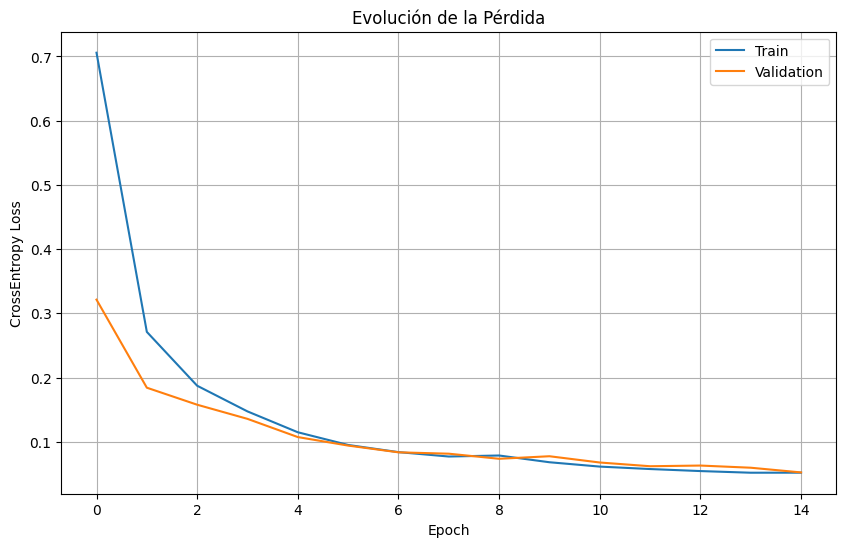

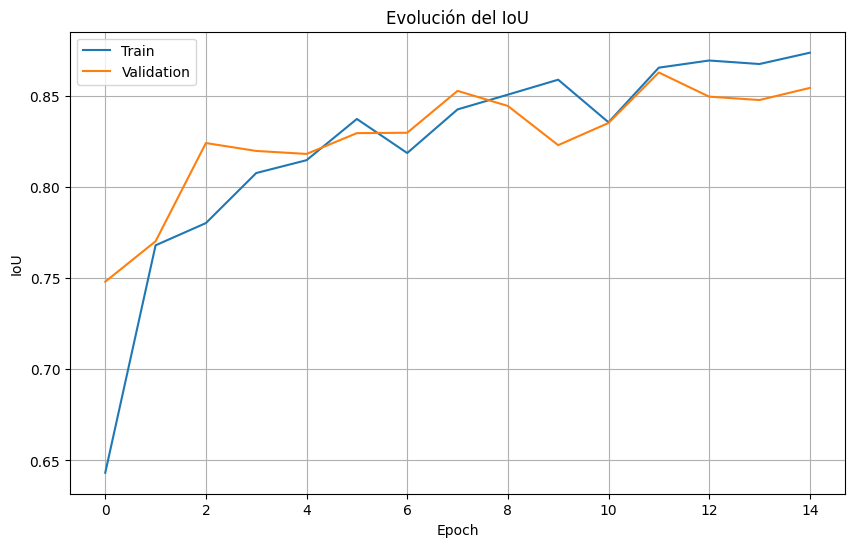

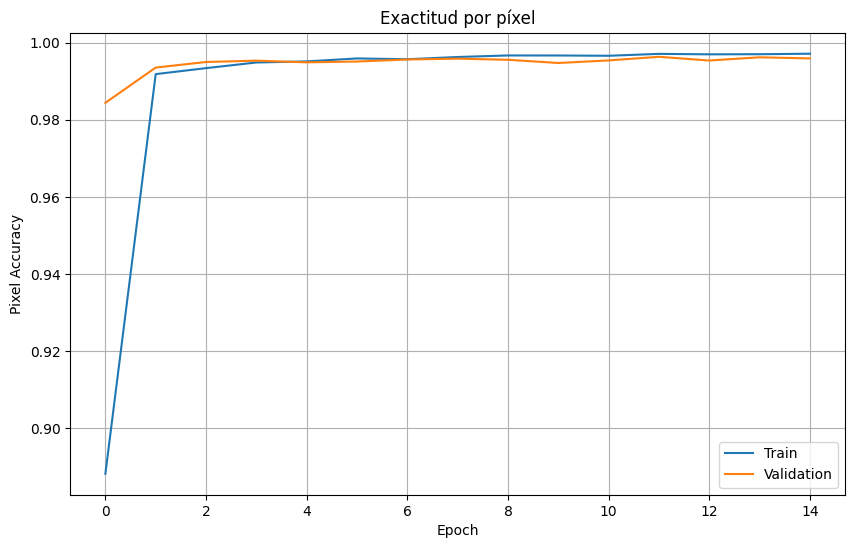

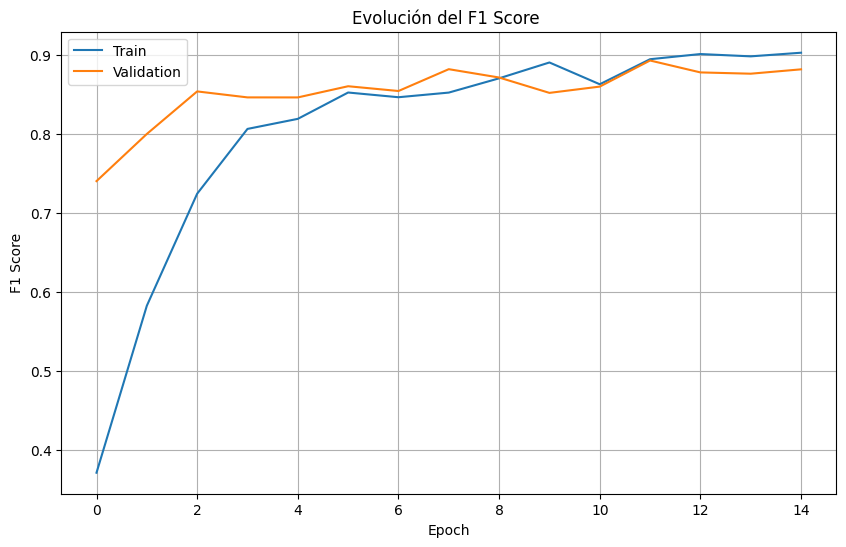

In [46]:
import matplotlib.pyplot as plt
import os

# Asegura carpeta de salida
os.makedirs("checkpoints/metric_plots", exist_ok=True)

def plot_metric(train_values, val_values, title, ylabel, filename):
    plt.figure(figsize=(10, 6))
    plt.plot(train_values, label="Train")
    plt.plot(val_values, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(f"checkpoints/metric_plots/{filename}.png")
    plt.show()

# 1. Pérdida (Loss) para detectar overfitting/underfitting
plot_metric(
    metrics["train_loss"],
    metrics["val_loss"],
    "Evolución de la Pérdida",
    "CrossEntropy Loss",
    "loss_comparison"
)

# 2. IoU (Intersección sobre Unión) - Métrica clave para segmentación
plot_metric(
    metrics["train_iou"],
    metrics["val_iou"],
    "Evolución del IoU",
    "IoU",
    "iou_comparison"
)

# 3. Pixel Accuracy - Proporción de píxeles correctamente clasificados
plot_metric(
    metrics["train_acc"],
    metrics["val_acc"],
    "Exactitud por píxel",
    "Pixel Accuracy",
    "accuracy_comparison"
)

# 4. F1 Score - Balance entre precisión y recall
plot_metric(
    metrics["train_f1"],
    metrics["val_f1"],
    "Evolución del F1 Score ",
    "F1 Score",
    "f1_comparison"
)


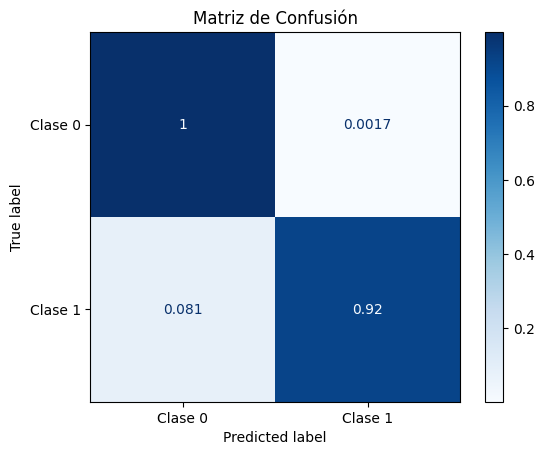

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, dataloader, device, num_classes=2, normalize=True, title="Matriz de Confusión"):
    all_preds = []
    all_targets = []

    model.eval()
    with torch.no_grad():
        for images, masks, _ in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy().flatten())
            all_targets.extend(masks.cpu().numpy().flatten())

    cm = confusion_matrix(all_targets, all_preds, labels=list(range(num_classes)), normalize='true' if normalize else None)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Clase {i}" for i in range(num_classes)])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.grid(False)
    plt.savefig("checkpoints/confusion_matrix.png")
    plt.show()

plot_confusion_matrix(model, val_loader, DEVICE, num_classes=2)


In [50]:
# ===============================
# EVALUADOR DE MODELO
# ===============================
def evaluate_model(model_path, dataloader, device, num_classes=2, pretrained=True):
    if pretrained:
        model = DPTSegmentationModel(
            num_classes=num_classes,
            path=model_path,
            backbone="vitl16_384",
        )
    else:
        model = DPTSegmentationModel(
            num_classes=num_classes,
            path=None,
            backbone="vitl16_384",
        )
        model.load_partial_weights(model_path)

    model.to(device)
    model.eval()

    iou_scores = []
    pixel_accuracies = []
    f1_scores = []

    with torch.no_grad():
        for images, masks, labels in tqdm(dataloader, desc=f"Evaluando {model_path}"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for p, t in zip(preds, masks):
                p_np = p.cpu().numpy()
                t_np = t.cpu().numpy()
                iou_scores.append(compute_iou(p_np, t_np, num_classes))
                pixel_accuracies.append(pixel_accuracy(p_np, t_np))
                f1_scores.append(f1_score(t_np.flatten(), p_np.flatten(), average="macro"))

    return {
        "IoU": np.nanmean(iou_scores),
        "Pixel Accuracy": np.mean(pixel_accuracies),
        "F1 Score": np.mean(f1_scores)
    }

In [51]:
eval_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

DATASET_PATH = "../input/dataset-v1/d1/"

eval_dataset = RoadSignSegmentationDataset(DATASET_PATH, transform=eval_transform)
eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Evaluación
print("Evaluando modelo preentrenado...")
results_pre = evaluate_model("DPT/weights/dpt_large-ade20k-b12dca68.pt", eval_loader, DEVICE, NUM_CLASSES, pretrained=True)
print("Modelo Preentrenado:", results_pre)

print("Evaluando modelo fine-tuned...")
results_fine = evaluate_model("checkpoints/dpt_finetuned.pt", eval_loader, DEVICE, NUM_CLASSES, pretrained=False)
print("Modelo Fine-Tuned:", results_fine)


Evaluando modelo preentrenado...


/kaggle/working/DPT/dpt/base_model.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  parameters = torch.load(path, map_location=torch.device("cpu"))


Cargando 438 de 442 parámetros del checkpoint.


Evaluando DPT/weights/dpt_large-ade20k-b12dca68.pt: 100%|██████████| 8/8 [00:27<00:00,  3.43s/it]


Modelo Preentrenado: {'IoU': 0.07841121126558483, 'Pixel Accuracy': 0.20980878736152023, 'F1 Score': 0.12311453241023301}
Evaluando modelo fine-tuned...


/kaggle/working/DPT/dpt/models.py:157: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  parameters = torch.load(path, map_location="cpu")


Cargando 442 de 442 parámetros del checkpoint.


Evaluando checkpoints/dpt_finetuned.pt: 100%|██████████| 8/8 [00:30<00:00,  3.85s/it]

Modelo Fine-Tuned: {'IoU': 0.8678022535121038, 'Pixel Accuracy': 0.9977543314949411, 'F1 Score': 0.9035466440920852}


In [24]:
# ================================================
# INTERACTIVO: ELECCIÓN DE MODELO + SUBIDA DE IMAGEN
# ================================================
from IPython.display import display
from ipywidgets import Dropdown, FileUpload
import io
from PIL import Image
import torch
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt

# -------- Dropdown para elegir modelo ----------
model_selector = Dropdown(
    options=[('Fine-tuned (model)', 'model'), ('Preentrenado (model2)', 'model2')],
    value='model',
    description='Modelo:',
)
display(model_selector)

# -------- Subida de imagen ----------
uploader = FileUpload(accept='image/*', multiple=False)
display(uploader)


Dropdown(description='Modelo:', options=(('Fine-tuned (model)', 'model'), ('Preentrenado (model2)', 'model2'))…

FileUpload(value=(), accept='image/*', description='Upload')

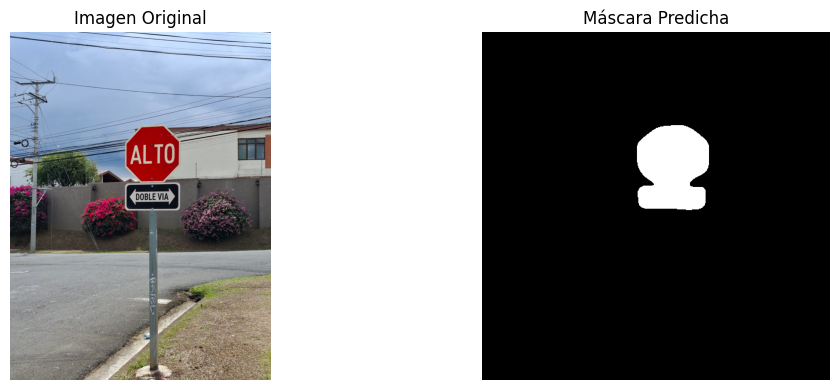

In [52]:
# ================================================
# PROCESAMIENTO Y PREDICCIÓN - VERSIÓN ROBUSTA
# ================================================

if uploader.value:
    # Detectar tipo de estructura
    if isinstance(uploader.value, dict):
        uploaded_file = list(uploader.value.values())[0]
    elif isinstance(uploader.value, tuple):
        uploaded_file = uploader.value[0]
    else:
        raise ValueError("Formato de archivo no reconocido")

    # Obtener imagen
    image_bytes = uploaded_file['content']
    image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    orig_image = image.copy()

    # Transformación
    transform = T.Compose([
        T.Resize((512, 512)),
        T.ToTensor(),
        T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ])
    input_tensor = transform(image).unsqueeze(0).to(DEVICE)

    # Selección de modelo
    selected_model = model if model_selector.value == 'model' else model2
    selected_model.to(DEVICE)
    selected_model.eval()

    with torch.no_grad():
        output = selected_model(input_tensor)
        pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    # Visualización
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(orig_image)
    plt.title("Imagen Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Máscara Predicha")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

else:
    print("⬆️ Subí una imagen para visualizar la predicción.")


In [26]:
# Descongelar todo
for param in model.parameters():
    param.requires_grad = True

# O: solo descongelar encoder
for param in model.pretrained.parameters():
    param.requires_grad = True

# Nuevo optimizador con lr más bajo
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


In [53]:
!mv /kaggle/working/checkpoints/dpt_finetuned.pt /kaggle/working/output

In [59]:
!ls -la /kaggle/working/output/dpt_finetuned.pt
!date

-rw-r--r-- 1 root root 1379864498 May 10 19:02 /kaggle/working/output/dpt_finetuned.pt
Sat May 10 07:12:42 PM UTC 2025
